In [1]:
import os
import numpy as np
import gzip
import pickle
import cv2
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = sio.loadmat('distorted_MNIST.mat')
test_data = sio.loadmat('testset_label.mat')

In [3]:
train_X = train_data['train_X']
train_y = train_data['train_y']
test_X = train_data['test_X']

In [4]:
test_y = test_data['test_y']

In [5]:
import sklearn.neighbors
from sklearn.decomposition import PCA
KNN_C = sklearn.neighbors.KNeighborsClassifier()

def train_and_eval( model, train_x, train_y, test_x, test_y):
    model.fit( train_x, train_y )
    p = model.predict( test_x )
    OA = sum(test_y==p)/len(test_y)
    return OA

In [6]:
train_X = train_X.reshape(train_X.shape[0],-1)
test_X = test_X.reshape(test_X.shape[0], -1)

In [7]:
train_y = train_y.flatten()
test_y = test_y.flatten()

# Using KNN on raw data will generate an accuracy of 63.7%

In [23]:
train_and_eval(KNN_C, train_X, train_y, test_X, test_y)

0.63685000000000003

# Using KNN on the first 20 PCs

In [26]:
flatten_distorted_X = np.concatenate((train_X, test_X))
train_index = np.arange(10000)
test_index = np.arange(10000,50000)
pca = PCA(n_components=20)
pcomp = pca.fit_transform(flatten_distorted_X)
X_pcomp_train,X_pcomp_test = [pcomp[train_index],pcomp[test_index]]
train_and_eval(KNN_C, X_pcomp_train, train_y, X_pcomp_test, test_y)

0.70609999999999995

In [8]:
flatten_distorted_X = np.concatenate((train_X, test_X))
train_index = np.arange(10000)
test_index = np.arange(10000,50000)
OA = []

pc_list = np.arange(5,81,5)
for pcs in pc_list:
    pca = PCA(n_components=pcs)
    pcomp = pca.fit_transform(flatten_distorted_X)
    X_pcomp_train,X_pcomp_test = [pcomp[train_index],pcomp[test_index]]
    OA.append(train_and_eval(KNN_C, X_pcomp_train, train_y, X_pcomp_test, test_y))

# Plot OA over num of PCs

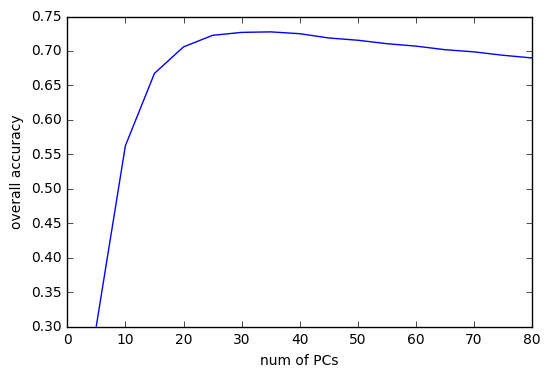

In [11]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.plot(pc_list, OA)
plt.xlabel('num of PCs')
plt.ylabel('overall accuracy')

In [8]:
flatten_distorted_X = np.concatenate((train_X, test_X))
train_index = np.arange(10000)
test_index = np.arange(10000,50000)
OA = []

pc_list = np.arange(25,35,1)
for pcs in pc_list:
    pca = PCA(n_components=pcs)
    pcomp = pca.fit_transform(flatten_distorted_X)
    X_pcomp_train,X_pcomp_test = [pcomp[train_index],pcomp[test_index]]
    OA.append(train_and_eval(KNN_C, X_pcomp_train, train_y, X_pcomp_test, test_y))

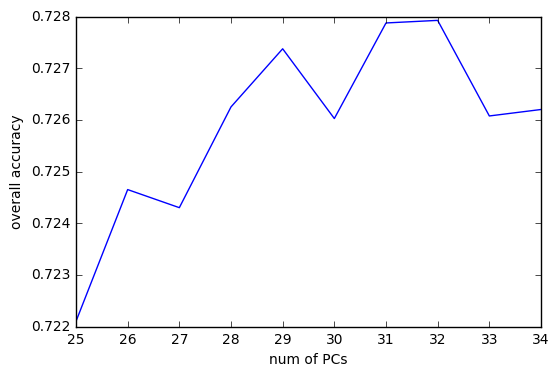

In [9]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.plot(pc_list, OA)
plt.xlabel('num of PCs')
plt.ylabel('overall accuracy')

In [10]:
max(OA)

0.72792500000000004

# It is computationally difficult to perform Isomap and LLE(basically kernel PCA based method) on this dataset. Even storing the kernel matrix in RAM is not trivial.

## Isomap

In [8]:
from sklearn.manifold import Isomap
import time

In [12]:
start_time = time.time()
num_datapoints = 5000 # number of datapoints that we use.
isomap = Isomap(n_neighbors=10, n_components=50, n_jobs=-1) # using all cpu cores
isomap.fit(flatten_distorted_X[:num_datapoints])
pcomp = isomap.transform(flatten_distorted_X)
X_pcomp_train,X_pcomp_test = [pcomp[train_index],pcomp[test_index]]
print(train_and_eval(KNN_C, X_pcomp_train, train_y, X_pcomp_test, test_y))
end_time = time.time()
print('roughly spend {:.2f}s'.format(end_time - start_time))

0.462675
roughly spend 103.90s


In [18]:
def isomap_experiment(n_neighbors, n_components):
    isomap = Isomap(n_neighbors, n_components, n_jobs=-1) # using all cpu cores
    isomap.fit(flatten_distorted_X[:num_datapoints])
    pcomp = isomap.transform(flatten_distorted_X)
    X_pcomp_train,X_pcomp_test = [pcomp[train_index],pcomp[test_index]]
    return train_and_eval(KNN_C, X_pcomp_train, train_y, X_pcomp_test, test_y)

In [16]:
n_neighbors_list = [10,20,30]
n_components_list = [20,30,40,50]
import itertools
params = list(itertools.product(n_neighbors_list, n_components_list))

In [20]:
OA = []
for param in params:
    OA.append(isomap_experiment(*param))
import pandas as pd
df = pd.DataFrame({'score':OA})

In [21]:
df.index = params
df

,score
"(10, 20)",0.465250
"(10, 30)",0.468700
"(10, 40)",0.463325
"(10, 50)",0.462675
"(20, 20)",0.513700
"(20, 30)",0.514800
"(20, 40)",0.508450
"(20, 50)",0.501200
"(30, 20)",0.534425
"(30, 30)",0.532300


## LLE

In [22]:
from sklearn.manifold import LocallyLinearEmbedding

In [23]:
start_time = time.time()
num_datapoints = 5000 # number of datapoints that we use.
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=50, n_jobs=-1) # using all cpu cores
lle.fit(flatten_distorted_X[:num_datapoints])
pcomp = isomap.transform(flatten_distorted_X)
X_pcomp_train,X_pcomp_test = [pcomp[train_index],pcomp[test_index]]
print(train_and_eval(KNN_C, X_pcomp_train, train_y, X_pcomp_test, test_y))
end_time = time.time()
print('roughly spend {:.2f}s'.format(end_time - start_time))

0.462675
roughly spend 91.31s


In [24]:
def lle_experiment(n_neighbors, n_components):
    lle = LocallyLinearEmbedding(n_neighbors, n_components, n_jobs=-1) # using all cpu cores
    lle.fit(flatten_distorted_X[:num_datapoints])
    pcomp = isomap.transform(flatten_distorted_X)
    X_pcomp_train,X_pcomp_test = [pcomp[train_index],pcomp[test_index]]
    return train_and_eval(KNN_C, X_pcomp_train, train_y, X_pcomp_test, test_y)

In [25]:
n_neighbors_list = [5,10,20,30]
n_components_list = [5,10,20,30,40,50]
import itertools
params = list(itertools.product(n_neighbors_list, n_components_list))

In [26]:
OA = []
for param in params:
    OA.append(isomap_experiment(*param))
import pandas as pd
df = pd.DataFrame({'score':OA})

In [27]:
df.index = params
df

,score
"(5, 5)",0.293175
"(5, 10)",0.401150
"(5, 20)",0.438350
"(5, 30)",0.446900
"(5, 40)",0.447375
"(5, 50)",0.449375
"(10, 5)",0.298125
"(10, 10)",0.424725
"(10, 20)",0.465250
"(10, 30)",0.468700
